In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import shap

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

x = train.drop(columns=["Survived", "Cabin", "Ticket", "PassengerId"])
y = train["Survived"]

train["Title"] = train["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
titles = train["Title"].value_counts()

def new_features(x):
    x_copy = x.copy()
    x_copy["Title"] = x_copy["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
    x_copy["Title"] = x_copy["Title"].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    x_copy['Title'] =x_copy['Title'].replace('Mlle', 'Miss')
    x_copy['Title'] = x_copy['Title'].replace('Ms', 'Miss')
    x_copy['Title'] = x_copy['Title'].replace('Mme', 'Mrs')
    x_copy["FamilySize"] = x_copy["Parch"]+ x_copy["SibSp"] + 1
    x_copy["IsAlone"] = (x_copy["FamilySize"] == 1).astype(int)
    x_copy["FarePerPerson"] = x_copy["Fare"]/x_copy["FamilySize"]
    return x_copy.drop(columns=["Name"])

Feature_Eng = FunctionTransformer(new_features)

num_col = ["Age", "FamilySize", "IsAlone", "FarePerPerson","Fare"]
cat_col = ["Title", "Embarked"]

num_feature = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="median")),
    ("Scaler", StandardScaler())
])
cat_feature = Pipeline(steps=[
    ("Imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessing = ColumnTransformer([
    ("num", num_feature, num_col),
    ("cat", cat_feature, cat_col)
])

Pipe = Pipeline(steps=[
    ("new_feature", Feature_Eng),
    ("preprocess", preprocessing),
    ("model", XGBClassifier(random_state=42,
                            eval_metric ="logloss",
                            ))
])


param_grid = {
    'model__n_estimators':[100, 400],
    'model__max_depth': [3, 4, 5],
    'model__learning_rate':[0.01, 0.05, 0.1],
    'model__subsample': [0.8, .9],
    "model__colsample_bytree": [0.8, .9, 1.0],
}

grid = GridSearchCV(
    estimator= Pipe,
    param_grid= param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs= -1,
    verbose= 2
)

grid.fit(x, y)

print("Best Parameters:")
print(grid.best_params_)

print("\nBest CV Accuracy:")
print(grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters:
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 400, 'model__subsample': 0.8}

Best CV Accuracy:
0.8767253632787197


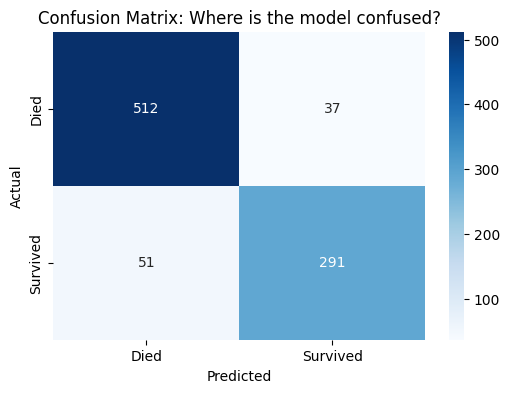

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       549
           1       0.89      0.85      0.87       342

    accuracy                           0.90       891
   macro avg       0.90      0.89      0.89       891
weighted avg       0.90      0.90      0.90       891



In [30]:
y_pred = grid.predict(x)

cm = confusion_matrix(y, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Died', 'Survived'], 
            yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Where is the model confused?')
plt.show()

print(classification_report(y, y_pred))

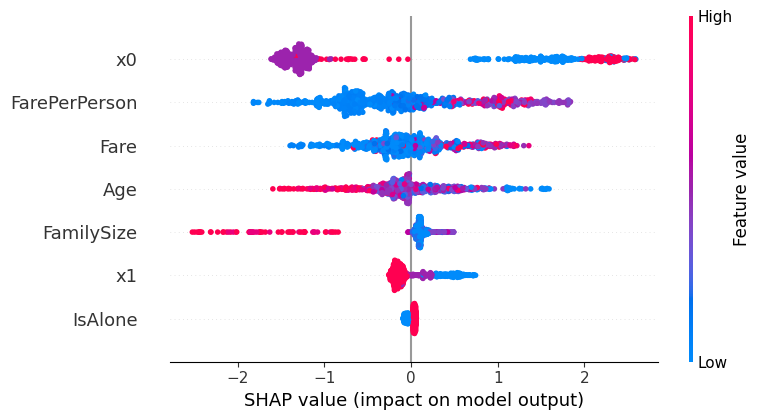

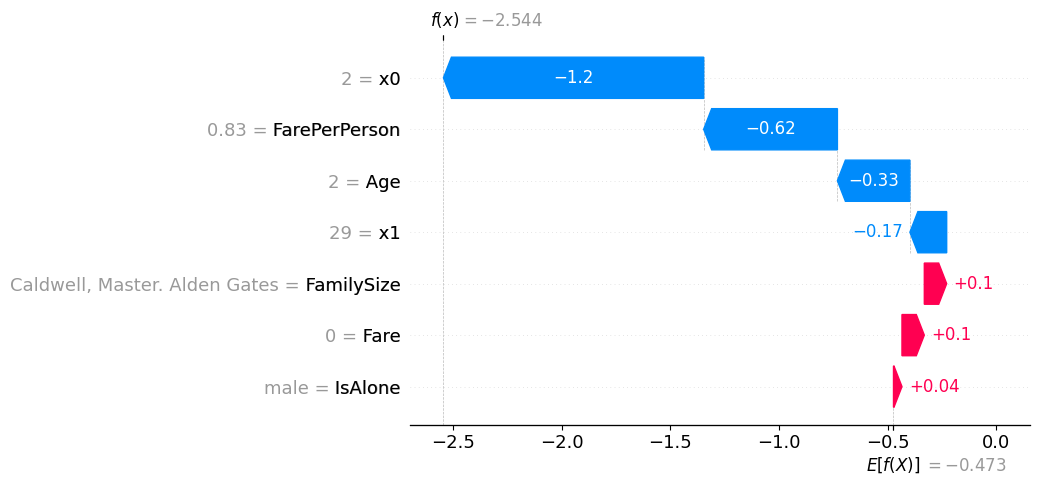

In [31]:
top_model = grid.best_estimator_

x_transformed = top_model.named_steps["preprocess"].transform(top_model.named_steps["new_feature"].transform(x))

cat_name = top_model.named_steps["preprocess"].named_transformers_["cat"]\
    .named_steps["encoder"].get_feature_names_out()

feature_names = num_col + list(cat_name)

explainer = shap.TreeExplainer(top_model.named_steps["model"])

shap_values = explainer.shap_values(x_transformed)

shap.summary_plot(shap_values, x_transformed, feature_names= feature_names)


shap.plots.waterfall(shap.Explanation(values= shap_values[77], base_values= explainer.expected_value, data= x.iloc[78], feature_names=feature_names))